In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
from scipy.stats import kde
from tqdm import tqdm

from research.datasets import AutoLoadedDataset
from research.evaluator import evaluate, stats_to_df
from research.regression import LinearFitSKL as FitterCls

In [2]:
PREFIX = 'lin'

if not os.path.exists('export'):
    os.mkdir('export')
if not os.path.exists('export/eps'):
    os.mkdir('export/eps')

plt.rcParams.update({
    "savefig.facecolor": (1, 1, 1, 1),
    "figure.figsize": (7, 4),
})

def save(fname):
    plt.savefig(f'export/{PREFIX}-{fname}', dpi=300)
    # Uncomment for eps files
    # plt.savefig(f'export/eps/{PREFIX}-{fname}.eps', dpi=1000, format='eps')

In [3]:
loaded = AutoLoadedDataset.load(seed=0)

Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\17_lmpavw.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\52_svmguide1.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\53_fourclass_scale.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\58_sarcasm_detection.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\77_WorkersCompensation.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\78_shill-bidding.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\79_art_daily_nojump3.arff
Unable to load C:\Users\Luke Yang G1\Documents\C3001\Y2\S2\FIT2082\project\datasets/auto\80_art_daily_small_noise2.arff
Loaded 70 datasets


In [4]:
RESULTS = {}
for name, dataset in tqdm(loaded.items()):
    eval_stats = evaluate(dataset, FitterCls, retrain_on_filtered=False)
    RESULTS[name] = stats_to_df(
        eval_stats,
        [
            'target_coverage',
            'expected_coverage',
            'coverage',
            'mse_expected',
            'mse_filtered',
            'mse_prop_base',
            'comparison_loss',
        ],
        name
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [02:27<00:00,  2.11s/it]


In [5]:
data = pd.concat(RESULTS.values(), ignore_index=True)
data.to_csv(f'data-{PREFIX}.csv')
data

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
0,0_kin8nm,0.1,0.205858,0.203907,0.017611,0.023148,0.569779,0.020315
1,0_kin8nm,0.2,0.205858,0.203907,0.017611,0.023148,0.569779,0.020315
2,0_kin8nm,0.3,0.315704,0.310134,0.019061,0.024004,0.590847,0.020315
3,0_kin8nm,0.4,0.445281,0.442308,0.023741,0.027338,0.672928,0.020315
4,0_kin8nm,0.5,0.530309,0.522589,0.025927,0.029807,0.733696,0.020315
...,...,...,...,...,...,...,...,...
695,9_wine_quality,0.6,0.673763,0.662818,0.394021,0.425985,0.819814,0.388566
696,9_wine_quality,0.7,0.800718,0.809084,0.427599,0.440004,0.846795,0.388566
697,9_wine_quality,0.8,0.800718,0.809084,0.427599,0.440004,0.846795,0.388566
698,9_wine_quality,0.9,0.929726,0.931486,0.492920,0.476783,0.917576,0.388566


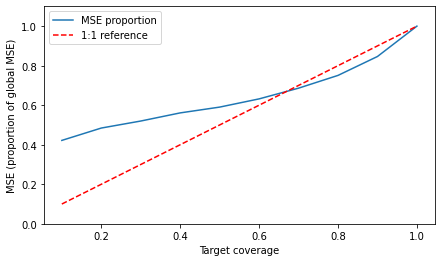

In [6]:
stats = data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

plt.plot(stats[:,0], stats[:,1], label='MSE proportion')
plt.plot([0.1, 1], [0.1, 1], 'r--', label='1:1 reference')

plt.xlabel('Target coverage')
plt.ylabel('MSE (proportion of global MSE)')
plt.ylim((0, 1.1))
plt.legend()
save('coverage-proportion reference')
plt.show()

In [7]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
}).reset_index().to_numpy()

array([[0.1       , 0.42188121],
       [0.2       , 0.48438392],
       [0.3       , 0.51988047],
       [0.4       , 0.56103198],
       [0.5       , 0.59036028],
       [0.6       , 0.63193347],
       [0.7       , 0.68617087],
       [0.8       , 0.75073255],
       [0.9       , 0.84637948],
       [1.        , 1.        ]])

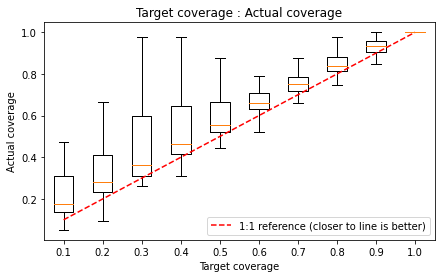

In [8]:
coverages = data.groupby('target_coverage').agg({
    'coverage': lambda x: list(x)
}).reset_index()['coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Actual coverage')
plt.title('Target coverage : Actual coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-actual')
plt.show()

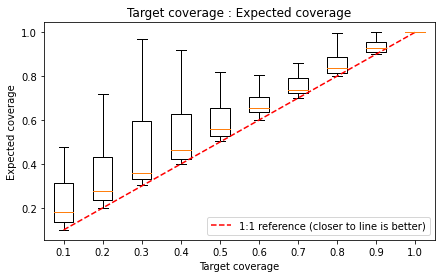

In [9]:
coverages = data.groupby('target_coverage').agg({
    'expected_coverage': lambda x: list(x)
}).reset_index()['expected_coverage']

plt.boxplot(coverages, showfliers=False)
plt.plot([1, 10], [0.1, 1], 'r--', label='1:1 reference (closer to line is better)')

plt.xlabel('Target coverage')
plt.ylabel('Expected coverage')
plt.title('Target coverage : Expected coverage')
plt.legend()
plt.xticks([*range(1, 11)], [f'{i/10}' for i in range (1, 11)])

save('coverage target-expected')
plt.show()

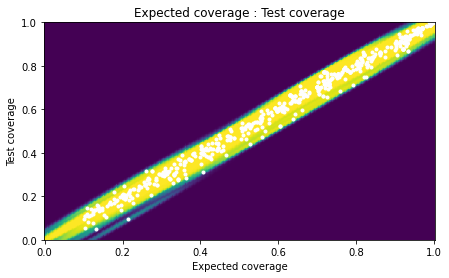

0.9963513273048819

In [10]:
x, y = data['expected_coverage'], data['coverage']

nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Expected coverage : Test coverage')
plt.xlabel('Expected coverage')
plt.ylabel('Test coverage')
save('expected-actual coverage heatmap')
plt.show()

x.corr(y)

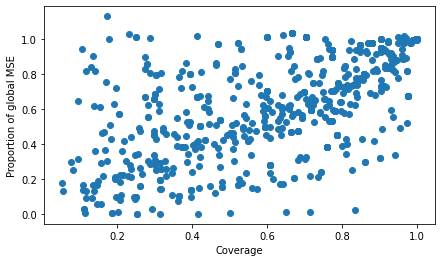

In [11]:
plt.scatter(data['coverage'], data['mse_prop_base'])

plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
plt.show()

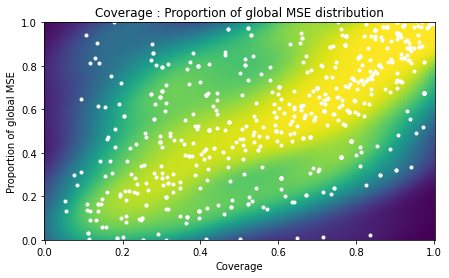

In [12]:
x, y = data['coverage'], data['mse_prop_base']
nbins = 300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[0:1:nbins*1j, 0:1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, -np.exp(-2 * zi.reshape(xi.shape)), shading='auto')
plt.scatter(x, y, color=(1,1,1,1), s=9)

plt.ylim((0, 1))
plt.title('Coverage : Proportion of global MSE distribution')
plt.xlabel('Coverage')
plt.ylabel('Proportion of global MSE')
save('coverage-proportion heatmap')
plt.show()

In [13]:
data.groupby('target_coverage').agg({
    'mse_prop_base': 'mean'
})

,mse_prop_base
target_coverage,
0.1,0.421881
0.2,0.484384
0.3,0.519880
0.4,0.561032
0.5,0.590360
0.6,0.631933
0.7,0.686171
0.8,0.750733
0.9,0.846379


In [14]:
# Ones where we did well
data[np.abs(data['mse_prop_base'] / data['coverage']) < 0.05]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
460,54_COMET_MC_SAMPLE,0.1,0.257228,0.252935,0.000017,0.000017,0.000761,0.005074
461,54_COMET_MC_SAMPLE,0.2,0.257228,0.252935,0.000017,0.000017,0.000761,0.005074
462,54_COMET_MC_SAMPLE,0.3,0.315144,0.312509,0.000026,0.000026,0.001183,0.005074
463,54_COMET_MC_SAMPLE,0.4,0.418704,0.414642,0.000060,0.000059,0.002679,0.005074
464,54_COMET_MC_SAMPLE,0.5,0.507576,0.501827,0.000107,0.000107,0.004839,0.005074
465,54_COMET_MC_SAMPLE,0.6,0.651929,0.649170,0.000224,0.000227,0.010271,0.005074
466,54_COMET_MC_SAMPLE,0.7,0.721112,0.715688,0.000297,0.000298,0.013463,0.005074
467,54_COMET_MC_SAMPLE,0.8,0.841610,0.834500,0.000452,0.000451,0.020374,0.005074
560,64_dataset_sales,0.1,0.119820,0.112689,0.005950,0.005782,0.004716,1.064574
610,69_Titanic,0.1,0.207477,0.185393,0.006552,0.005620,0.007958,0.526732


In [15]:
# Ones where we did bad
data[(data['mse_prop_base'] / data['coverage']) > 5]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
10,10_wind,0.1,0.126489,0.135413,5.439970e+00,9.698095e+00,0.904629,9.878771e+00
50,14_pm10,0.1,0.156146,0.105528,2.123481e+04,3.954883e+04,0.941018,3.902915e+04
51,14_pm10,0.2,0.225914,0.170854,2.311299e+04,4.750357e+04,1.130292,3.902915e+04
60,15_pollen,0.1,0.183196,0.178038,1.117391e+06,1.205528e+06,1.002341,1.320404e+06
80,18_no2,0.1,0.152824,0.115578,1.934874e+04,2.934986e+04,0.815395,3.275603e+04
400,47_disclosure_x_bias,0.1,0.123116,0.128788,2.522718e+08,5.019104e+08,0.837725,6.352534e+08
410,48_SWD,0.1,0.134775,0.140351,1.442839e-01,3.318135e-01,0.814789,4.572974e-01
501,59_ilpd-numeric,0.2,0.214286,0.094421,2.856849e-02,1.307205e-01,0.648291,1.918867e-01


In [16]:
# Success stories
data[(data['mse_prop_base'] < 0.2) & (data['coverage'] > 0.8)]

,dataset,target_coverage,expected_coverage,coverage,mse_expected,mse_filtered,mse_prop_base,comparison_loss
467,54_COMET_MC_SAMPLE,0.8,0.84161,0.8345,0.000452,0.000451,0.020374,0.005074


In [17]:
def plot_stats(name):
    stats = RESULTS[name]

    plt.plot(stats['coverage'], stats['mse_filtered'], marker='^', label='Actual MSE')
    plt.plot(stats['coverage'], stats['mse_expected'], marker='o', label='Predicted MSE')
    plt.axhline(stats['comparison_loss'][0], linestyle='--', color='r', label='Random forest performance')

    plt.xlabel('Coverage')
    plt.ylabel('MSE')
    plt.title(f'Predicted and actual MSE for {name}')
    plt.legend()
    save(name)
    plt.show()

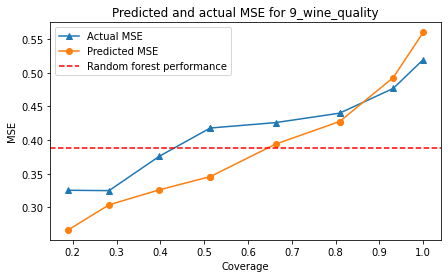

In [18]:
plot_stats('9_wine_quality')

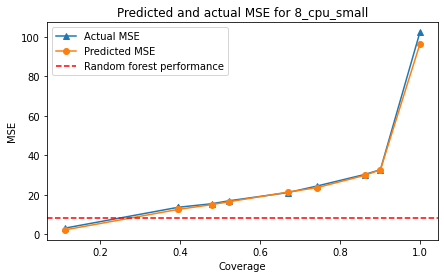

In [19]:
plot_stats('8_cpu_small')

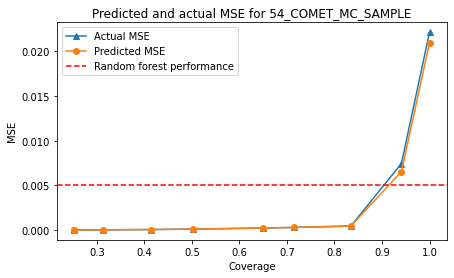

In [20]:
plot_stats('54_COMET_MC_SAMPLE')

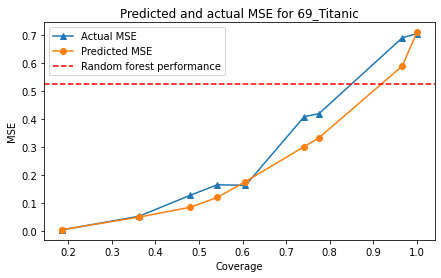

In [21]:
plot_stats('69_Titanic')

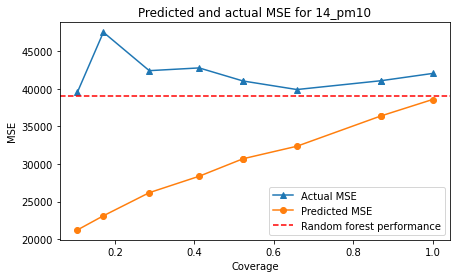

In [22]:
plot_stats('14_pm10')

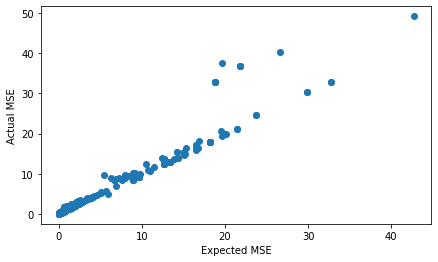

In [23]:
mask = (data['mse_expected'] < 100) & (data['mse_filtered'] < 100)

plt.scatter(data['mse_expected'][mask], data['mse_filtered'][mask])
plt.xlabel('Expected MSE')
plt.ylabel('Actual MSE')
save('expected to actual')
plt.show()

In [24]:
data['coverage'].corr(data['mse_prop_base'])

0.6435352621343996

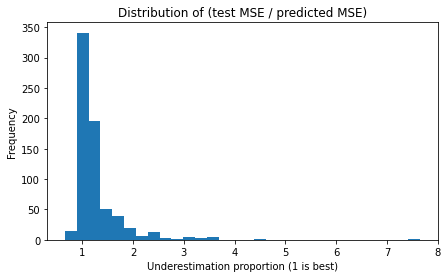

In [25]:
plt.hist(data['mse_filtered'] / data['mse_expected'], bins=30)

plt.title('Distribution of (test MSE / predicted MSE)')
plt.xlabel('Underestimation proportion (1 is best)')
plt.ylabel('Frequency')
save('underestimation dist')
plt.show()

In [26]:
ratios =  data['mse_filtered'] / data['mse_expected']
ratios.mean(), ratios.std()

(1.2711748988839606, 0.512926173621545)

In [27]:
ratios.mean() + 1.96 * ratios.std()

2.276510199182189

In [28]:
(ratios > 1.5).mean()

0.15571428571428572

In [29]:
def find_max_coverage_perfmatch(name):
    stats = RESULTS[name]
    comparison = stats['coverage'][stats['mse_filtered'] < stats['comparison_loss']]
    if comparison.size:
        return comparison.max()
    return 0

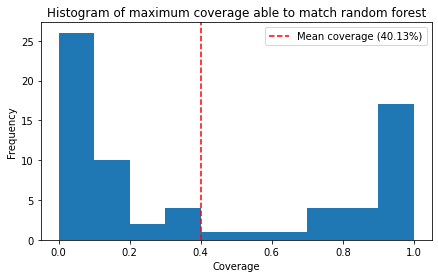

In [30]:
perfmatch = np.array([*map(find_max_coverage_perfmatch, RESULTS.keys())])

plt.hist(perfmatch, bins=10)
plt.axvline(perfmatch.mean(), color='r', linestyle='--',
            label=f'Mean coverage ({perfmatch.mean():.2%})')

plt.title('Histogram of maximum coverage able to match random forest')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
save('cov-hist')
plt.show()

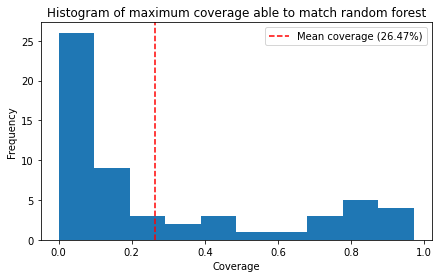

In [31]:
perfmatch_no1 = perfmatch[perfmatch != 1]

plt.hist(perfmatch_no1, bins=10)
plt.axvline(perfmatch_no1.mean(), color='r', linestyle='--',
            label=f'Mean coverage ({perfmatch_no1.mean():.2%})')

plt.title('Histogram of maximum coverage able to match random forest')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.legend()
save('cov-hist-no1')
plt.show()